## References

* https://www.kaggle.com/code/currie32/predicting-fraud-with-tensorflow

* https://www.kaggle.com/code/joparga3/in-depth-skewed-data-classif-93-recall-acc-now

* https://www.youtube.com/watch?v=frM_7UMD_-A

* https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

* https://www.youtube.com/watch?v=ekp3JFmVA1Y

* https://www.kaggle.com/code/gpreda/credit-card-fraud-detection-predictive-models#Predictive-models

* ChatGPT

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time
import warnings

from collections import Counter 
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from itertools import cycle
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, f1_score, classification_report, precision_score, accuracy_score, average_precision_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, cross_val_predict, train_test_split #todo #StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle


In [2]:
warnings.filterwarnings("ignore")

In [3]:
df_cc = pd.read_csv("creditcard.csv") # Dataset from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

# Weake a copy of our dataframe so we can compare copies of it when comparing different approaches and solutions
original_df = df_cc 

In [4]:
df_cc.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Most of the features confidential and are replaced with a variable name, expect for time and amount

In [5]:
df_cc.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# Check for null or missing values
df_cc.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Good! Seems that there are no missing values.

Let's now find out more about the balance of the dataset

In [7]:
# Let's now compare the fraudulent and normal transactions
print('Fraud')
print(df_cc.Time[df_cc.Class == 1].describe()) # Displays all fraudulent transactions
print()
print('normal')
print(df_cc.Time[df_cc.Class == 0].describe())
print(f'Of our total cases of {len(df_cc)} cases, only {len(df_cc[df_cc.Class==1])/len(df_cc[df_cc.Class==0])*100:.2f}% of which are fraudulent')

Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64
Of our total cases of 284807 cases, only 0.17% of which are fraudulent


The count of fraudulent transactions is 492, which matches the information described on the dataset

This means that the dataset if unbalanced and a using a typical accuracy score to evaluate our classifications, such as majority class, to assign values to all records, we'd have  ahigh accurazy but also be classifying all "1" incorrectly.

When dealing with a dataset with this classification this unbalanced, we can do several things:

* Collect more data? Would be good, but it's not an option for us

* Changing the performance metric:
    * confusio nmatrix to calculate precision, Recall
    * F1score (weighted average of precision recall)
    * Kappa - classification accuracy that is normalized by imbalance of the classes 
    * ROC curves - calculates sensitivity/specificity ratio

* Resampling dataset
    * This method will process the data to achieve a 50-50 ratio
    * We can achieve this by using either over-sampling, which adds copies of the under-represented class( Good when you have little data),
    * Or under-sampling, which deletes records of the over-represented class(Good when we have much data)



We'll explore and compare using resampling and not using it, by using a logistic regression classifier.

We'll also explore and evaluate the models by using some of the metrics mentioned above

Then also repeat the best resampling/no-resampling method by turning parameters in the logistic regression classifier, then perform classification model using other classification algoritms

#### There are many ways to go on about this data.
Let's first do visualize some light/basic comparisons before we dive deep

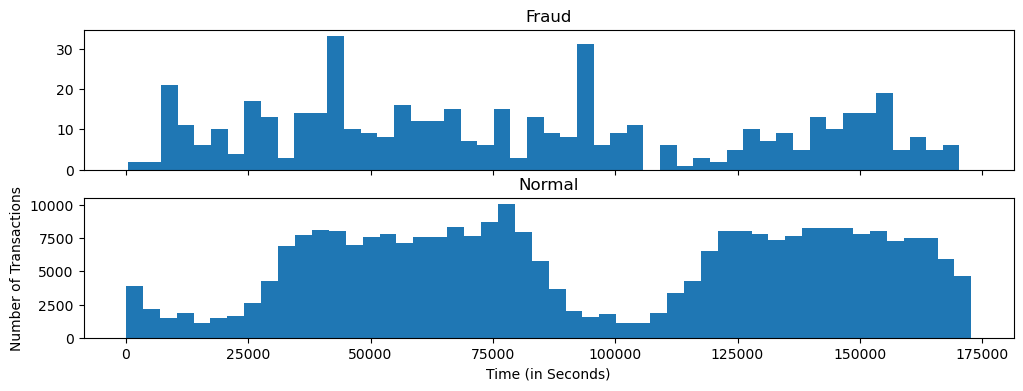

In [8]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 50 # bins is the amount of "bars" in our histogram to display

ax1.hist(df_cc.Time[df_cc.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df_cc.Time[df_cc.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

The distribution of transactions based on time is somewhat even, but fraudulent transactions are more uniformly distributed while normal tx have a more cyclical distribution.

This could be used to make it easier to detect a fraudulent transaction during non-peak time periods

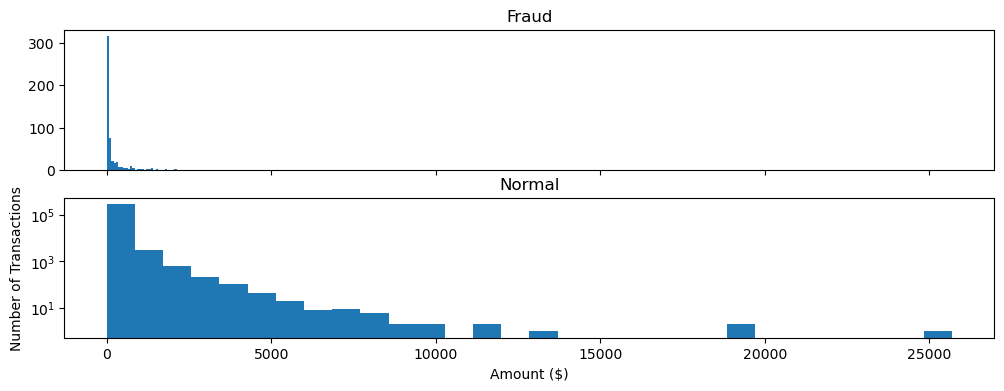

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 30
ax1.hist(df_cc.Amount[df_cc.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df_cc.Amount[df_cc.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Most fraudulent transactions are less than 100.
Fraudulent transactions have a maximum value far less than normal transactions.
fraudulent max at 2 125.87 
and normal max at 25 691.16

In [10]:
df_cc['Amount_max_fraud'] = 1
df_cc.loc[df_cc.Amount <= 2125.87, 'Amount_max_fraud'] = 0 


### Let's explore Time & Amount 

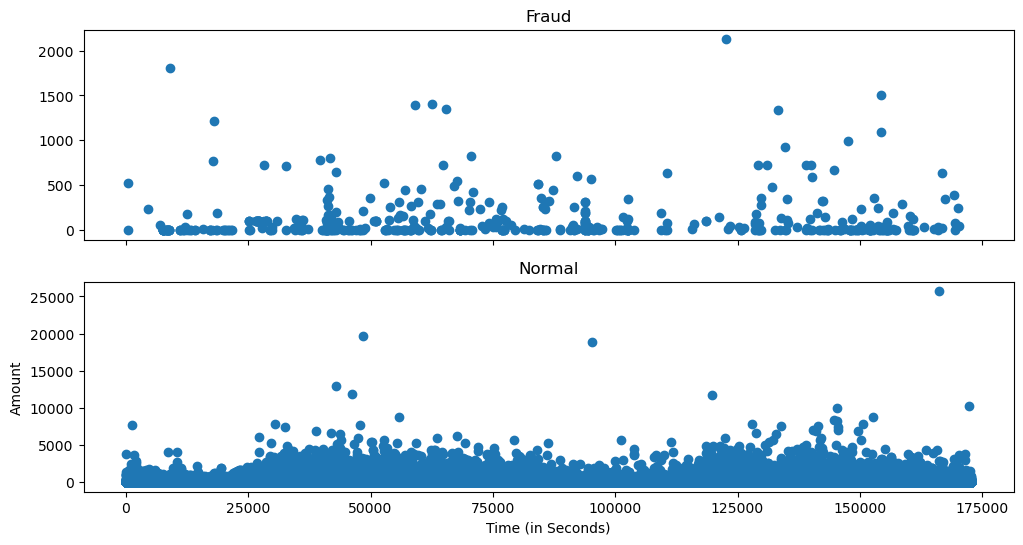

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))

ax1.scatter(df_cc.Time[df_cc.Class == 1], df_cc.Amount[df_cc.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(df_cc.Time[df_cc.Class == 0], df_cc.Amount[df_cc.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

This hasn't so far given us much to work with.
But we have yet to explore the other features.


As we're dealing with an imbalance dataset and looking at the distribution of Time and Amount, aswell as the other columns, we should probably scale them.
We also need to take in to account that we need to create a subsample of the dataframe to have an equal number of Fraud or NonFraud cases.


There are multiple ways to do this, both using SMOTE(over and under-sample) aswell as only using oversampling or undersampling.

We'll start by undersampling to get a 50-50 ratio of fraud and nonfraud transactions

I've tried several approaches to undersampling strategies.
First i'll walk through one of the approaches closer to my intial attempt, and what explain common misstakes as we go through them.

In [12]:
# We use a StandardScaler here, which was my initial attempt.
# But i've learned since that RobustScaler is less prone to outliers

data_cc = df_cc

data_cc['normAmount'] = StandardScaler().fit_transform(df_cc['Amount'].values.reshape(-1, 1))
data_cc = data_cc.drop(['Time','Amount'],axis=1)
data_cc.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_max_fraud,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0,-0.073403


Data is now prepared, so let's resample (using undersampling) to get a 50-50 ratio by selecting random samples from both classes

In [13]:
X = data_cc.iloc[:, data_cc.columns != 'Class']
y = data_cc.iloc[:, data_cc.columns == 'Class']

# We know that there are 492 counts of fraud from our previous usage of .describe on the classes
fraud_count = 492 # Alternatively can get this by using = len(data_cc[data_cc.Class == 1])
fraud_indices = np.array(data_cc[data_cc.Class == 1].index)

normal_indices = data_cc[data_cc.Class == 0].index

# Randomised rows
random_normal_indices = np.random.choice(normal_indices, fraud_count, replace = False)
random_normal_indices = np.array(random_normal_indices)

# append the two indices we have
under_sampled_indices = np.concatenate([fraud_indices, random_normal_indices])

# Create the under-sampled dataset
under_sampled_data = data_cc.iloc[under_sampled_indices, :]

X_undersampled = under_sampled_data.iloc[:, under_sampled_data.columns != 'Class']
y_undersampled = under_sampled_data.iloc[:, under_sampled_data.columns == 'Class']

# Display the ratios of the normal, frauduluent and total transaction in our resampled data.
print(f'Total transactions: {len(under_sampled_data)}')
print(f'We have a total of {len(under_sampled_data[under_sampled_data.Class == 0])} of normal transactions and {len(under_sampled_data[under_sampled_data.Class == 1])} fraudulent transactions')

Total transactions: 984
We have a total of 492 of normal transactions and 492 fraudulent transactions


#### Split into train & test, then use cross validation

In [14]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Number of transactions train dataset: ", len(X_train))
print("Number of transactions test dataset: ", len(X_test))
print("Total transactions: ", len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(X_undersampled
                                                                                                   ,y_undersampled
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Number transactions train dataset: ", len(X_train_undersampled))
print("Number transactions test dataset: ", len(X_test_undersampled))
print("Total number of transactions: ", len(X_train_undersampled)+len(X_test_undersampled))


Number of transactions train dataset:  199364
Number of transactions test dataset:  85443
Total transactions:  284807

Number transactions train dataset:  688
Number transactions test dataset:  296
Total number of transactions:  984


Since we're dealing with imbalanced datasets measuring wit the standard accurazy score wouldn't yield accurate and useful results.

Think of a confusion matrix and how Accurazy, Precision and Recall work.
* Accuracy = (TP+TN)/total
* Precision = TP/(TP+FP)
* Recall = TP/(TP+FN)

Since we have imbalanced data, it is likely we predict False Negatives on our observations, ie we predict a normal transaction but it is fraudulent.

Recall helps captures this.

* One major takeaway is the more we increase recall, the less precison we have and vice-versa. 
* But in our case, we'd prefer predicting a fraudulent transaction and it turns out it's a normal one, rather than misstakenly letting fraudulent transactions pass through.

In [15]:
def printing_Kfold_scores(x_train_data, y_train_data):
    kf = KFold(n_splits=5, shuffle=False)

    # Different C parameters
    c_param_range = [0.01, 0.1, 1, 10, 100]

    results_table = pd.DataFrame(index=range(len(c_param_range)), columns=['C_parameter', 'Mean recall score'])
    results_table['C_parameter'] = c_param_range

    j = 0
    for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, (train_index, test_index) in enumerate(kf.split(x_train_data), start=1):
            x_train_fold = x_train_data.iloc[train_index]
            y_train_fold = y_train_data.iloc[train_index]
            x_test_fold = x_train_data.iloc[test_index]

            lr = LogisticRegression(C=c_param, penalty='l1', solver='liblinear')

            lr.fit(x_train_fold, y_train_fold)

            y_pred_undersample = lr.predict(x_test_fold)

            recall_acc = recall_score(y_train_data.iloc[test_index], y_pred_undersample)
            recall_accs.append(recall_acc)
            print('Iteration', iteration, ': recall score =', recall_acc)

        results_table.loc[j, 'Mean recall score'] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score', np.mean(recall_accs))
        print('')

    print(results_table)
    print(type(results_table))
    
    results_table['Mean recall score'] = pd.to_numeric(results_table['Mean recall score'])

    #best_c = results_table.loc[results_table['Mean recall score'].idxmax(), 'C_parameter'] # original    
    best_c_row = results_table.loc[results_table['Mean recall score'].idxmax()]
    best_c = best_c_row['C_parameter']
    mean_recall_score = best_c_row['Mean recall score']
    print('Best C parameter:', best_c)
    print('Mean recall score:', mean_recall_score)

    print('*********************************************************************************')
    print('Best model to choose from cross validation is with C parameter =', best_c)

    return best_c


What does this big function above do?

It uses Kfold cross-validation for logistic regression models with different values of regularization parameter C and calculates the best values for us.

Here's a breakdown of it:
1. We initialize a KFold object with 5 splits and no shuffling. KFold is a cross validation technique that iteratively trains and evalutes the model on different combination of these splits.
2. We define a c_param_range with the different regularization values of C.
3. We create an empty dataframe with columns for our C_parameter and mean recall score
4. We iterate over the values of c_param_range and printing the values of the parameters
5. We initialize an empty list recall_accs to store the recall scores for each iteration of the KFold.
6. kf.split returns the indices of the training and test data for each split/fold in the KFold.
7. For each split it selects the corresponding data from x_train_data and y_train_data
8. We create a LogisticRegression object lr with the current c_param value and is the model is trained.
9. We make predictinos and calculates the recall score and saves the value in our recall_accs list.
10. It calculates the mean recall score from recall_accs and stores it in our dataframe results_table and then prints the mean recall score
11. It repeats step 5-10 for eachv alue in c_param_range
12. We convert the mean recall score column in our results_table_ to numeric
13. We find and print the highest mean recall score and the corresponding c_parameter value

In [16]:
best_c = printing_Kfold_scores(X_train_undersampled,y_train_undersampled)


-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration 1 : recall score = 0.9315068493150684
Iteration 2 : recall score = 0.9178082191780822
Iteration 3 : recall score = 1.0
Iteration 4 : recall score = 0.972972972972973
Iteration 5 : recall score = 0.9696969696969697

Mean recall score 0.9583970022326186

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration 1 : recall score = 0.8493150684931506
Iteration 2 : recall score = 0.863013698630137
Iteration 3 : recall score = 0.9491525423728814
Iteration 4 : recall score = 0.918918918918919
Iteration 5 : recall score = 0.9090909090909091

Mean recall score 0.8978982275011994

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration 1 : recall score = 0.863013698630137
Iteration 2 : recall score = 0.8904109589041096
Iteration 3 : recall score = 0.98305084745762

Now when we've tested different parameters and found the best model for our cross validation, let's create a confusion matrix

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False, # Can normalize the data if you want the % for eachc ell in the matrix
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Predictions and confusion matrix
Let's evaluate our predictions and performances.
We still want to use recall, but since our undersampled data has a 50-50 ratio it doesn't have a skewness, which makes recall less important

Recall metric in the testing dataset:  0.9387755102040817


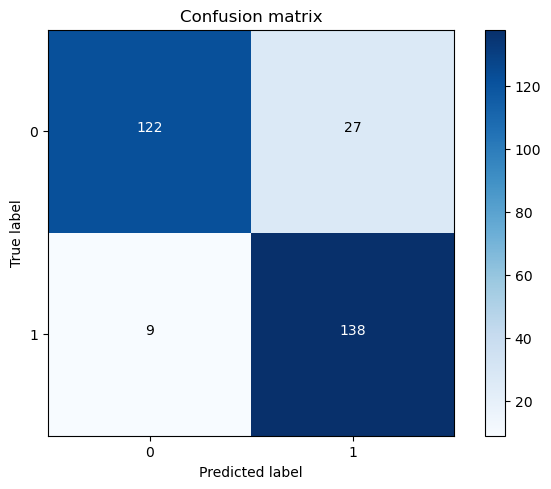

In [18]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test dataset
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
lr.fit(X_train_undersampled,y_train_undersampled.values.ravel())
y_pred_undersampled = lr.predict(X_test_undersampled.values)

# Create our confusion matrix
cnf_matrix = confusion_matrix(y_test_undersampled,y_pred_undersampled)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()


We have around 93% recall accurazy on the generalised unseed test dataset.
However, we need to remember this is on the undersampled set.

Let's apply the model we fitted and test it on the WHOLE data

Recall metric in the testing dataset:  0.9251700680272109


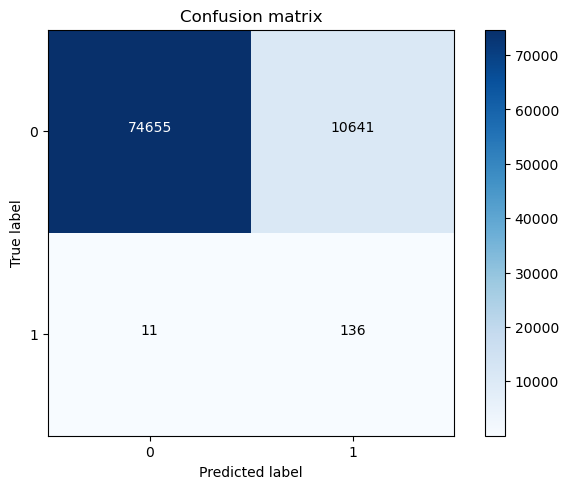

In [19]:
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
lr.fit(X_train_undersampled,y_train_undersampled.values.ravel())
y_pred = lr.predict(X_test.values)

cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()


Since we now tested it on the whole dataset it does have a skewness this time, but despite that we still reach around 92% recall.

We can use a Precision-Recall Curve(ROC) to help us understand this data.
Since our problems relies on catching the "positive" class more than ignoring the negative 
* A reminder: We would rather have a stricter model which gives false positives, ie predicting a transaction as fraudulent but turns out it was normal, rather than letting fraudulent slip by and be counted as normal

Both ROC and AUC can be helpful when determining the predicting as a whole and ensuring we're not making as many errors

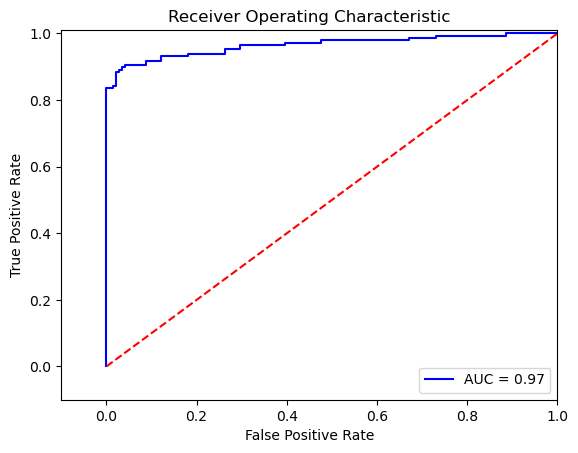

In [20]:
# ROC curve
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
y_pred_undersampled_score = lr.fit(X_train_undersampled,y_train_undersampled.values.ravel()).decision_function(X_test_undersampled.values)

fpr, tpr, thresholds = roc_curve(y_test_undersampled.values.ravel(),y_pred_undersampled_score)
roc_auc = auc(fpr,tpr)

# Plot the thing
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


At this point, it does give us a good metric.

But a good reminder here is we used undersampled data which was very small in size.

It could be good to repeat the process with different undersampled samples and re-check if the parameters used last iteration is still the most effective.


Before we move on to a showing a similair but likely a more thorough approach to handling the data, let's first quickly use Logistic Regression Classifier on our skewed data.

How would that provide any value?

It could be interested to compare our result so far on the skewed data and compare the differences.

It's possibly that the skewness will introduce issues that might be hard to capture, which leads to a less effective algorithm.

Two points to consider
* Taking into account that the fact the train and test datasets are vastly bigger than the undersampled ones, a K-fold cross validation is most likely needed.
* Splitting the data to 60% training/20% cross_validation/20% test should be optimal, but for the sake of consistency let's not make any changes to our approach. (Just take note that K-fold is computationally more expensive)


In [21]:
# find the best_c in the whole train sets, not just the undersampled sets this time
best_c = printing_Kfold_scores(X_train,y_train)


-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration 1 : recall score = 0.4925373134328358
Iteration 2 : recall score = 0.6027397260273972
Iteration 3 : recall score = 0.6833333333333333
Iteration 4 : recall score = 0.5692307692307692
Iteration 5 : recall score = 0.45

Mean recall score 0.5595682284048672

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration 1 : recall score = 0.5671641791044776
Iteration 2 : recall score = 0.6164383561643836
Iteration 3 : recall score = 0.6833333333333333
Iteration 4 : recall score = 0.5846153846153846
Iteration 5 : recall score = 0.525

Mean recall score 0.5953102506435158

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration 1 : recall score = 0.5522388059701493
Iteration 2 : recall score = 0.6164383561643836
Iteration 3 : recall score = 0.7166666666666667
Itera

Recall metric in the testing dataset:  0.6190476190476191


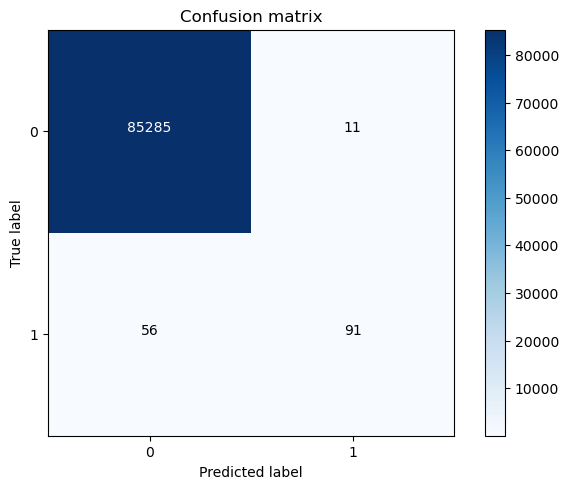

In [22]:
lr = LogisticRegression(C = best_c, penalty = 'l1', solver='liblinear')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersampled = lr.predict(X_test.values)

cnf_matrix = confusion_matrix(y_test,y_pred_undersampled)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()


### Before continuing... changing classification threshold.
* After undersampling the data, we can see our algorithm is much better at detecting fraudulent transactions. By changing the threshhold we can also tweak our final classificaton
* So far, we built the classification model and then predicted unseen data using it, using the predict() method to decide whether a record should belong to 1 or 0.
* However, there is another method, predict_proba(), which returns the probabilites for each class. We can use this by changng the threshhold to assign a record to class 1, therefor we can controll precision and recall.
* Let's this this out with our undersampled data if we use best C_param = 0.01


Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.9795918367346939
Recall metric in the testing dataset:  0.9387755102040817
Recall metric in the testing dataset:  0.891156462585034
Recall metric in the testing dataset:  0.8367346938775511
Recall metric in the testing dataset:  0.782312925170068
Recall metric in the testing dataset:  0.5850340136054422


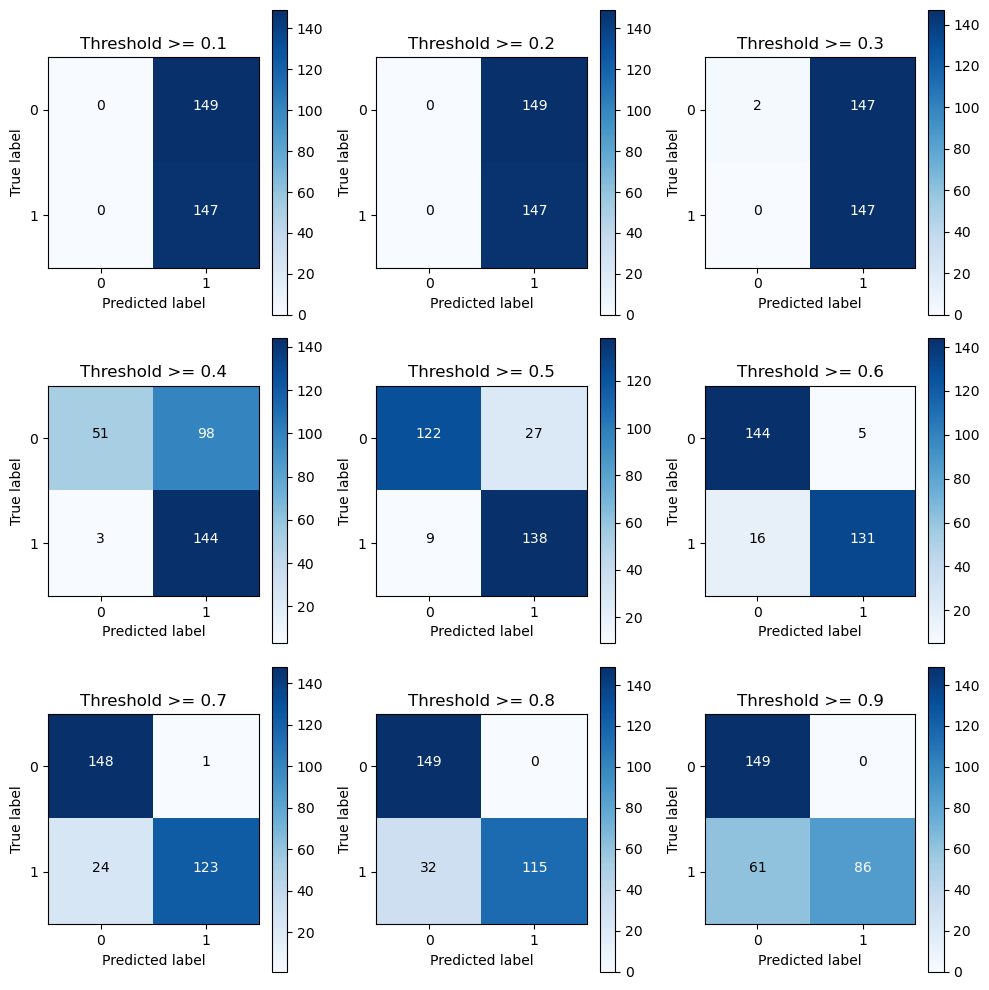

In [23]:
lr = LogisticRegression(C = 0.01, penalty = 'l1', solver='liblinear')
lr.fit(X_train_undersampled,y_train_undersampled.values.ravel())
y_pred_undersampled_proba = lr.predict_proba(X_test_undersampled.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersampled_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Create confusion matrix
    cnf_matrix = confusion_matrix(y_test_undersampled,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot our matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 


We notice that the lower we set the required probability to put a certain entry in the class 1 category, more entries will be put in that bucket

This means that we are likely to see an increase in recall(Where we want all the 1's), but at a decrease in precision(missclassification)

## Revisiting our goal:
We don't want to miss a fraud transaction.
So even though we want our goal metric to be recall, we also want the model to be accurate.

We can use threshold changing with the help of the Precisio-Recall curve.
We can create visuallize the performance of our model depending on our choise of threshold, and then investigate where the best spot is to have a high enough recall without sacrificing a high accurazy.


#### Investigate Precision-Recall curve and area under this curve.


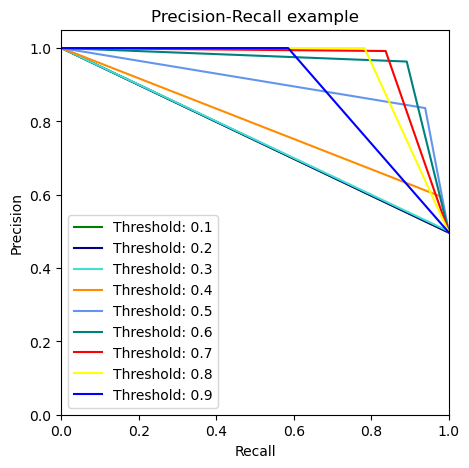

In [24]:
lr = LogisticRegression(C = 0.01, penalty = 'l1', solver='liblinear')
lr.fit(X_train_undersampled,y_train_undersampled.values.ravel())
y_pred_undersampled_proba = lr.predict_proba(X_test_undersampled.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['green', 'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersampled_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test_undersampled,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")


A reminder on what a Precision Recall curve is:
Precision and recall are two commonly used evaluation metrics in classification tasks, especially when the classes are not balanced. Here's a brief explanation of these terms:

* Precision: Precision measures the proportion of correctly predicted positive instances out of all instances predicted as positive. It focuses on the accuracy of positive predictions. Precision is calculated as the ratio of true positives to the sum of true positives and false positives.

* Recall: Recall, also known as sensitivity or true positive rate, measures the proportion of correctly predicted positive instances out of all actual positive instances. It focuses on the ability to identify positive instances. Recall is calculated as the ratio of true positives to the sum of true positives and false negatives.

Using a precision-recall curve provides a graphical representation of the trade-off between precision and recall for different classification thresholds or decision boundaries. The curve is created by plotting precision on the y-axis and recall on the x-axis, and it summarizes the model's performance across a range of thresholds.

## A conclusion before trying another similar, yet different approach
#### Let's break down our approach:
* We first scaled the time and amount column using a StandardScaler
* We then created a undersampled dataset with a 50-50 ratio(492 fraudulent and 492 normal transactions)
* We talked briefly about Accuracy, Precision and Recall aswell as how they all are related to out goal
* We used KFold, LogisticRegression and recall score to experiment with different parameters to find the best possible KFold score.  We also visualised the different parameters and iterations of it
* We then wanted to evaluate our predicions and performance of our approach, so we created a confusion matrix and then compared the results of undersampled and whole datasets.
* We used ROC to visualize the True Positive and False Positive rates, and noted the results
* Using the same approach so far, we explored using the same process on the skewed data and compare the differences.  The theory is that skewness will introduce issues that's hard to capture, therefor making the algorithm less effective.
* The recall score of the skewed data was around 62% compared to around 92% from our initial attempt without skewed data
* Since undersampled data outperformed the whole data(with skewness) by a vast margin, we explored changing the threshhold as to tweak our final classification.
* We used the predict()-method to classify as a record as 1 or 0, but then explored using the predict_proba()-method which returns the probabilities for each class. This is where we explored the different results by changing the threshold
* We used a Precision-Recall curve on our dataset to gain further insight about the performance and metrics


# 1 Let's do a similar, yet different approach

### A reminder:
Our dataframe is unbalanced, and therefor we have the following issues
* Overfitting: Our classification models will assume that in most cases there are no fraud(classify fraudulent transactions as normal ones). We want our model is to be certain when a fraud occurs.
* Wrong Correlations: Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features.


From using the describe method on our dataset earlier we can see most of our data has already been scaled, and that the unscaled columns "Amount and Time" are something that would be benefitial to scale

In [25]:
# From using the describe method on our dataset earlier most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# A big difference i learned from my first approach was that RobustScaler is less prone to outliers compared to StandardScaler

#Let's quickly reset our modified df_cc to the original state after just being read from csv
df_cc = original_df

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df_cc['scaled_amount'] = rob_scaler.fit_transform(df_cc['Amount'].values.reshape(-1,1))
df_cc['scaled_time'] = rob_scaler.fit_transform(df_cc['Time'].values.reshape(-1,1))

df_cc.drop(['Time','Amount'], axis=1, inplace=True)

In [26]:
 # TODO - Combine this and cell above?
scaled_amount = df_cc['scaled_amount']
scaled_time = df_cc['scaled_time']

df_cc.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df_cc.insert(0, 'scaled_amount', scaled_amount)
df_cc.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df_cc.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_max_fraud,normAmount
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0,0.244964
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0,-0.342475
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0,1.160686
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0,0.140534
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0,-0.073403


#### Splitting the Data (Original DataFrame)
* Before proceeding with the Random UnderSampling technique we have to separate the orginal dataframe. Why? 
* For testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. 
* The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

A note of KFold vs StratifiedKFold.
When we are dealing with classification problem of imbalance class distribution, we have to use StratifiedKFold. 

* KFold devides the dataset into k folds. 
* StratifiedKFold ensures that each fold of dataset has the same proportion of observations with a given label.

This was a miss i initially made, and also saw other examples of, but has since learned.

![alternatvie text](https://i.imgur.com/lClmYp7.jpeg)

In [27]:
print('No Frauds', round(df_cc['Class'].value_counts()[0]/len(df_cc) * 100,2), '% of the dataset')
print('Frauds', round(df_cc['Class'].value_counts()[1]/len(df_cc) * 100,2), '% of the dataset')

X = df_cc.drop('Class', axis=1)
y = df_cc['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

### We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
### original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

#TODO - possibly skip this displaying part

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

 # TODO - fix prints
print('Label Distributions: \n')
#print(train_counts_label, ',', original_ytrain, ',', len(original_ytrain))
print(f'{train_counts_label}, {len(original_ytrain)}')
print(test_counts_label/ len(original_ytest))
print('1 ', type(test_counts_label)) ##
print('2 ', len(original_ytest))
print('3 ', type(test_counts_label/len(original_ytest))) ##
#print('type of all: ', type(test_counts_label), ',', type(len(original_ytest),',', type(test_counts_label/len(original_ytest))))
print(f'{train_counts_label/ len(original_ytrain)}') ##


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[227452    394], 227846
[1. 0.]
1  <class 'numpy.ndarray'>
2  56961
3  <class 'numpy.ndarray'>
[1. 0.]


## Random under-sampling (A better version)
#### Steps:
* The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
* Once we determine how many instances are considered fraud transactions (Fraud = "1") , we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.
* After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.
#### Note:
The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 492 non-fraud transaction from 284,315 non-fraud transaction)

In [28]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples
df_cc = df_cc.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df_cc.loc[df_cc['Class'] == 1]
non_fraud_df = df_cc.loc[df_cc['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows again to ensure randomness
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Class,Amount_max_fraud,normAmount
44457,1.570600,-0.502168,-0.897737,-0.324670,2.676269,1.074281,-1.027288,0.183702,0.055951,-0.046191,...,0.826860,-0.245436,0.811293,-0.271566,0.571851,-0.008854,-0.146054,0,0,0.184113
45732,-0.293440,-0.495988,-3.843009,3.375110,-5.492893,6.136378,2.797195,-2.646162,-1.668931,-2.617552,...,0.719652,0.451125,-0.258094,0.656129,0.556676,0.739383,-0.203050,1,0,-0.349231
183090,-0.167680,0.481209,2.048779,0.172753,-1.738718,0.529255,0.154181,-1.495179,0.263458,-0.378663,...,0.704368,-0.030531,-0.095101,0.249867,-0.099427,-0.005457,-0.031185,0,0,-0.313249
8845,0.117236,-0.852888,-4.727713,3.044469,-5.598354,5.928191,-2.190770,-1.529323,-4.487422,0.916392,...,0.254983,0.628843,-0.238128,-0.671332,-0.033590,-1.331777,0.705698,1,0,-0.231728
39183,10.547474,-0.528237,-0.964567,-1.643541,-0.187727,1.158253,-2.458336,0.852222,2.785163,-0.303609,...,0.536204,1.634061,0.203839,0.218749,-0.221886,-0.308555,-0.164500,1,0,2.752604


#### Equally distributing and correlating
Let's make sure that our datased is correctly balanced before we proceed

In [29]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

# plotting is a bit overkill/unnecessary.
#sns.countplot('Class', data=new_df) #colors?
#plt.title('Equally Distributed Classes', fontsize=14)
#plt.show()

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


### Correlation matrix
**Notes:** 
We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

Taking the other features into account with a correlation matrix was not something done in our previous attempt

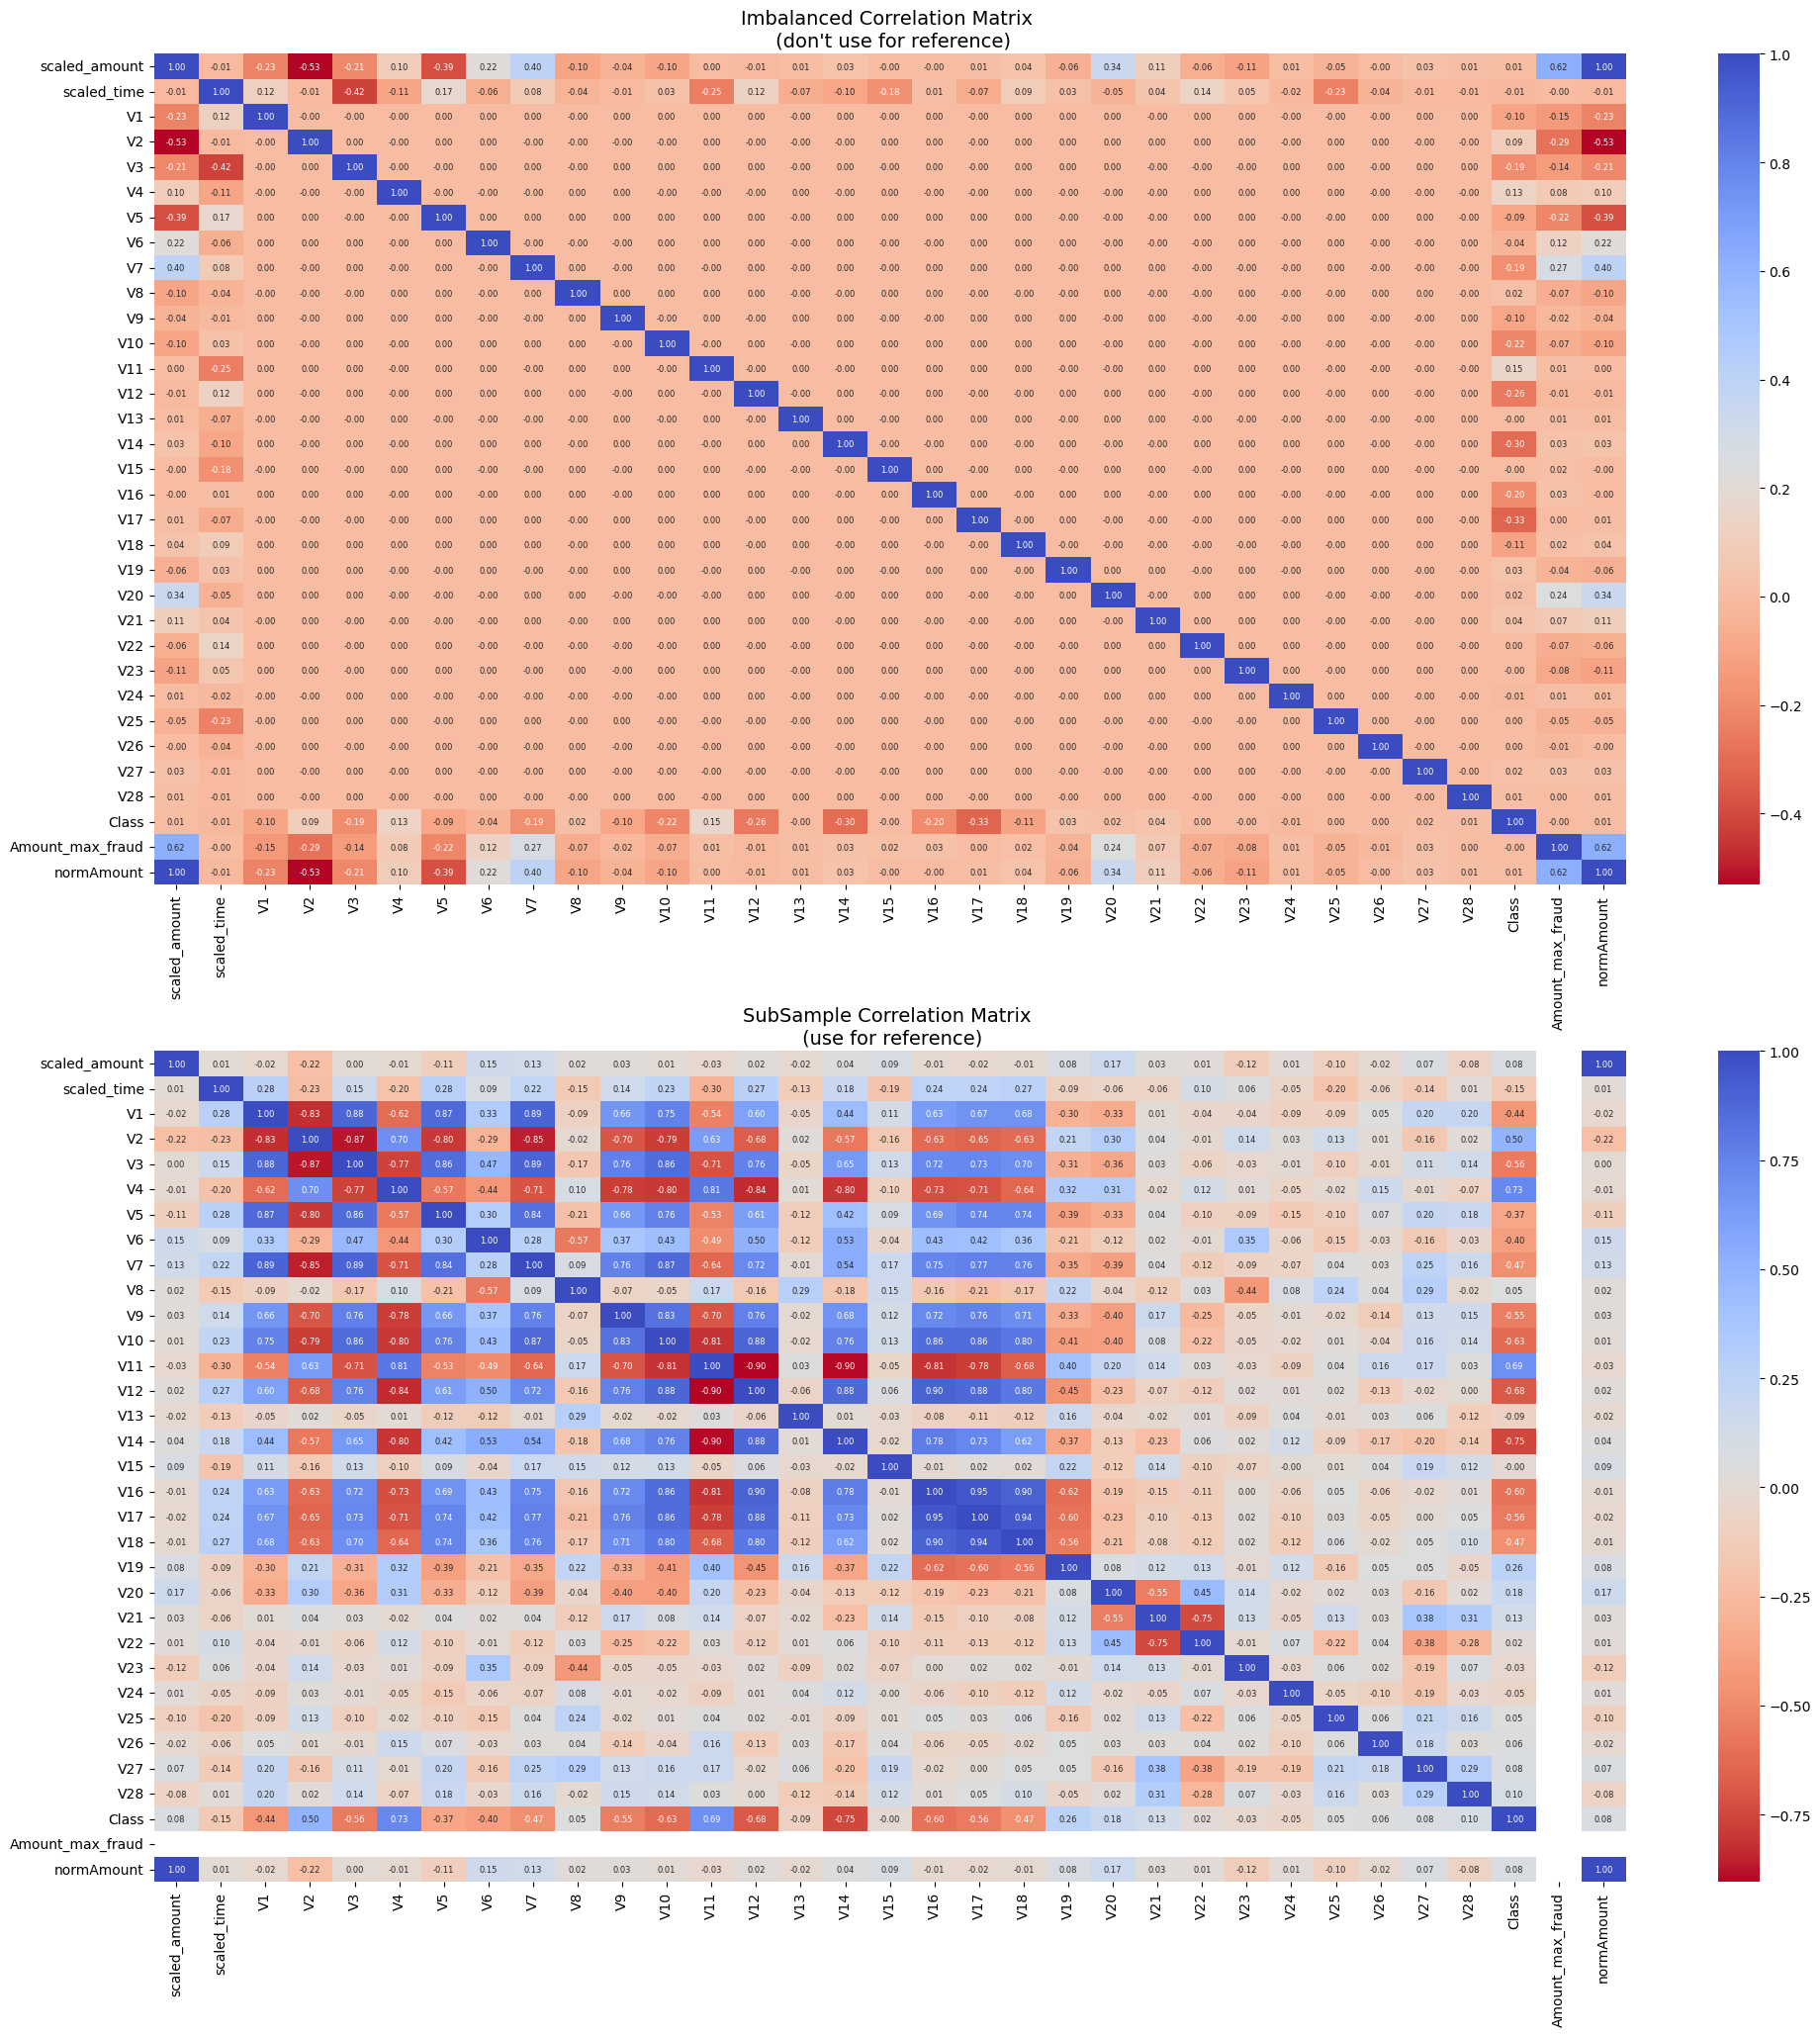

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,24))

# Entire DataFrame, just to get a picture of how badly it performs on underbalanced dataset
corr = df_cc.corr()
sns.heatmap(corr, cmap='coolwarm_r',  annot=True, fmt=".2f", annot_kws={'size':6}, ax=ax1) # Edited to display cell correlation
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


# Our subsample dataframe, this is where our correlation matrix really shines
sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r',annot=True, fmt=".2f", annot_kws={'size':6}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()


In our case, it's import to remember that we have to use a correlation matrix where the dataframe is inbalanced, as it's important that we use the subsampled dataframe in other to see which features that has impactful correlations to a fraudulent transaction


### Summary and Explanation:
* Negative Correlations(The lower values, the more likely for it to be a fraudulent transaction): v14(-0.75), v12(-0.68), v10(-0,63), v16(-0,60), v3 & v18 both with (-0,56)
* Positive Correlation(The higher values, the more likely it for be to be fraudulent): v2, v4, v11 and v9 and biggets positives


* BoxPlots: We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions.

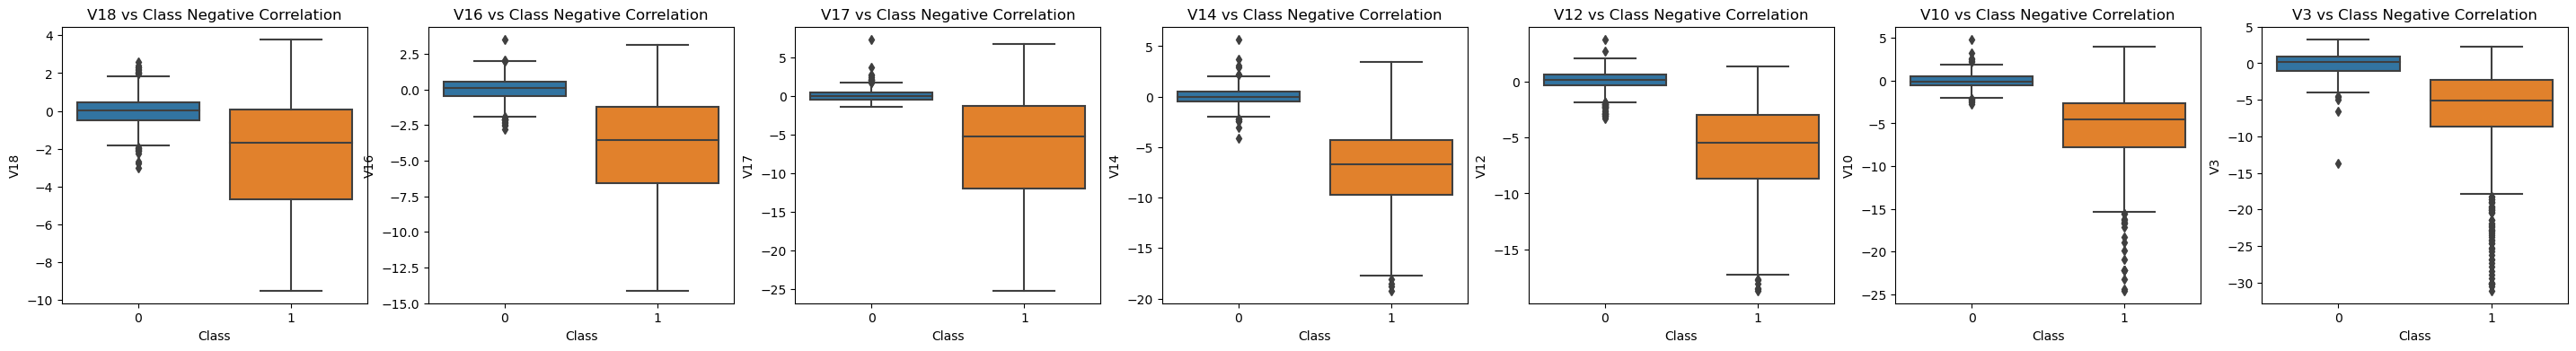

In [31]:
f, axes = plt.subplots(ncols=7, figsize=(36,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V18", data=new_df, ax=axes[0]) # "palette=colors" removed
axes[0].set_title('V18 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V16", data=new_df, ax=axes[1])
axes[1].set_title('V16 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V17", data=new_df, ax=axes[2])
axes[2].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, ax=axes[3])
axes[3].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, ax=axes[4])
axes[4].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, ax=axes[5])
axes[5].set_title('V10 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V3", data=new_df, ax=axes[6])
axes[6].set_title('V3 vs Class Negative Correlation')

plt.show()

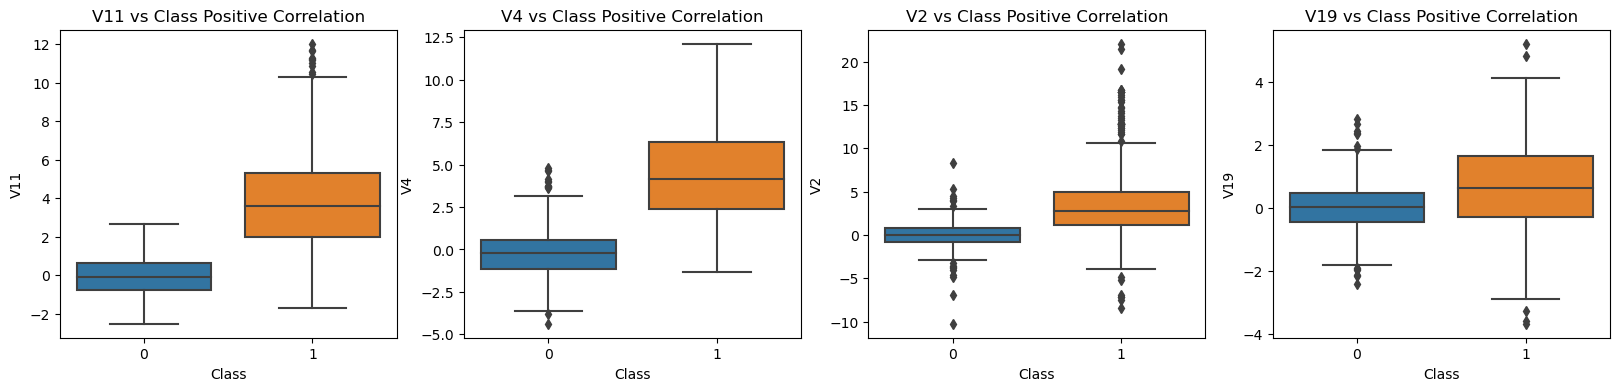

In [32]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## With our approach being slightly different and used a few additional tools, such as correlation matrix and boxplots, let's now get moving to Classifiers and explore the results

#### Small explanation for what we're about to do:
We'll use a few classifiers such as LogisticRegression, KnearestNeighbor, SVC and DecisionTreeClassifier.

**Usually**, LogisticRegression is more accurate than the alternatives in cases like ours, but we'll put that to the test.

**GridSearchCV** will be used to explore the best parameters for 

### Classifiers for this

In [33]:
# Undersampling before cross validating (prone to overfit, usually a bad idea)
# But we'll do it just to compare the differences of undersampling before vs during cross-validation
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [34]:
# Our data is already scaled we should split our training and test sets
# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Turn the values into an array for our classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [36]:
# Let's try out a few simple classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [37]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(f'Classifiers:  {classifier.__class__.__name__} Has a training score of, {training_score.mean()*100:.2f}% accuracy score')


Classifiers:  LogisticRegression Has a training score of, 94.03% accuracy score
Classifiers:  KNeighborsClassifier Has a training score of, 93.26% accuracy score
Classifiers:  SVC Has a training score of, 93.52% accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of, 90.85% accuracy score


Our scores are high even before applying cross validation

We'll use GridSearchCV to find the best parameters

In [38]:
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# Get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

#KNears
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
# tree best estimator
tree_clf = grid_tree.best_estimator_


Let's try with overfitted data, just to compare results

In [39]:
# Overfitting Case
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print(f'Logistic Regression Cross Validation Score: {log_reg_score.mean()*100:.2f}%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print(f'Knears Neighbors Cross Validation Score, {knears_score.mean()*100:.2f}%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print(f'Support Vector Classifier Cross Validation Score, {svc_score.mean()*100:.2f}%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print(f'DecisionTree Classifier Cross Validation Score, {tree_score.mean()*100:.2f}%')


Logistic Regression Cross Validation Score: 94.66%
Knears Neighbors Cross Validation Score, 93.39%
Support Vector Classifier Cross Validation Score, 94.41%
DecisionTree Classifier Cross Validation Score, 92.76%


Create a DataFrame with all the scores and the classifiers names.

Now with what we've learned, here's a reminder to oversample or undersample your training data DURING cross-validation, not before.
If we undersample before, our dataset is more likely to be overfit

In [40]:
# Therefore, we will undersample during cross validating
undersampled_X = df_cc.drop('Class', axis=1)
undersampled_y = df_cc['Class']

for train_index, test_index in sss.split(undersampled_X, undersampled_y):
    print("Train:", train_index, "Test:", test_index)
    undersampled_Xtrain, undersampled_Xtest = undersampled_X.iloc[train_index], undersampled_X.iloc[test_index]
    undersampled_ytrain, undersampled_ytest = undersampled_y.iloc[train_index], undersampled_y.iloc[test_index]
    
undersampled_Xtrain = undersampled_Xtrain.values
undersampled_Xtest = undersampled_Xtest.values
undersampled_ytrain = undersampled_ytrain.values
undersampled_ytest = undersampled_ytest.values 

undersampled_accuracy = []
undersampled_precision = []
undersampled_recall = []
undersampled_f1 = []
undersampled_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
#X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values) # SWAPPED - original
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersampled_X.values, undersampled_y.values) # SWAPPED - new(fit_sample -> fit_resample)

print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersampled_Xtrain, undersampled_ytrain):
    undersampled_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersampled_model = undersampled_pipeline.fit(undersampled_Xtrain[train], undersampled_ytrain[train])
    undersampled_prediction = undersampled_model.predict(undersampled_Xtrain[test])
    
    undersampled_accuracy.append(undersampled_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersampled_precision.append(precision_score(original_ytrain[test], undersampled_prediction))
    undersampled_recall.append(recall_score(original_ytrain[test], undersampled_prediction))
    undersampled_f1.append(f1_score(original_ytrain[test], undersampled_prediction))
    undersampled_auc.append(roc_auc_score(original_ytrain[test], undersampled_prediction))

Train: [ 56959  56960  56961 ... 284804 284805 284806] Test: [    0     1     2 ... 57190 57944 58075]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 56959  56960  56961 ... 113922 113923 113924]
Train: [     0      1      2 ... 284804 284805 284806] Test: [113884 113925 113926 ... 170896 170897 170898]
Train: [     0      1      2 ... 284804 284805 284806] Test: [161545 162442 162855 ... 230180 230287 230825]
Train: [     0      1      2 ... 230180 230287 230825] Test: [227841 227842 227843 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [41]:
# Create a DataFrame with all the scores and the classifiers names.
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

Let's print out the scores, then print the plots

In [42]:
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9848813909895934
KNears Neighbors:  0.932977829487428
Support Vector Classifier:  0.9826772671449809
Decision Tree Classifier:  0.9263589942473014


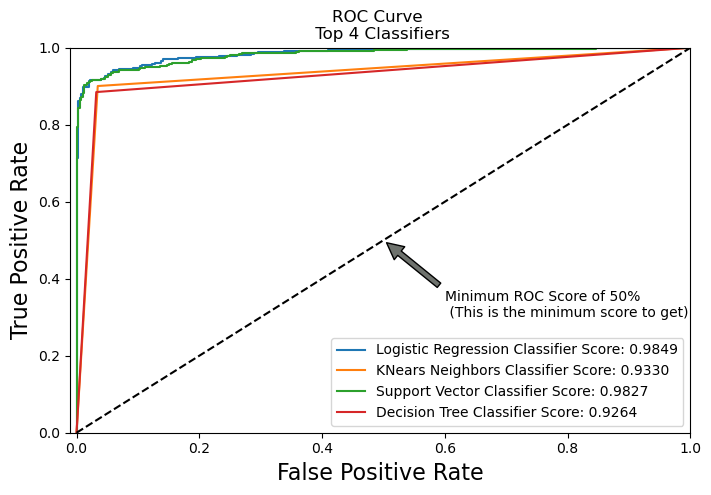

In [43]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(8,5)) #16, 8 original
    plt.title('ROC Curve \n Top 4 Classifiers')
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

A reminder - The better our model is at precision(selective), the less cases it will detect.
If we lower the precision, there are more cases our model can detect

**Precision:** True Positives/(True Positives + False Positives)

**Recall:** True Positives/(True Positives + False Negatives) 

After 0.9-0.92, our precision starts to descend, but overall it's still a prety decent recall score

We used a ROC curve for all our used classifiers, but we can go deeper and 

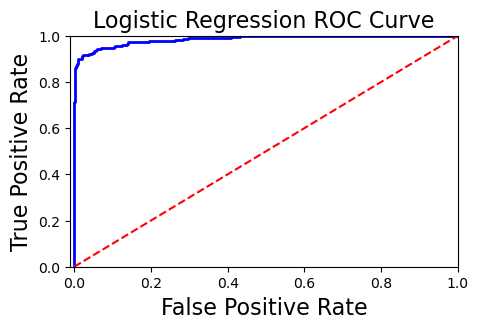

In [44]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(5,3))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [45]:
precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)
y_pred = log_reg.predict(X_train)

print('How the scores should look like, taken from our undersampled case')
print('Scores')
print("Accuracy Score: {:.2f}".format(np.mean(undersampled_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersampled_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersampled_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersampled_f1)))

print('\n\n')
print('Our current overfitting case')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))

How the scores should look like, taken from our undersampled case
Scores
Accuracy Score: 0.76
Precision Score: 0.00
Recall Score: 0.25
F1 Score: 0.00



Our current overfitting case
Recall Score: 0.89
Precision Score: 0.82
F1 Score: 0.85
Accuracy Score: 0.85


Let's take one last reminder of our scores above, and why there's sucha difference between our good results, and our overfitting results.

* Precision Score: Precision measures the proportion of true positive predictions out of the total positive predictions (true positives + false positives). It indicates the model's ability to avoid false positives. In this case, a low precision score suggests that the model is not good at accurately predicting the positive class.

* Recall Score: Recall, also known as sensitivity or true positive rate, measures the proportion of true positives predicted correctly out of the actual positive samples (true positives + false negatives). It represents the model's ability to capture positive instances. A low recall score indicates that the model is not effective at identifying the positive class correctly.

* F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balance between the two metrics and is useful when the dataset is imbalanced. A low F1 score suggests that the model's overall performance in terms of precision and recall is low.


Our results from the undersampled dataset has very low scores, could generally in the usual cases indicate that the model is prioritizing recall(capturing positive, ie capturing fraudulent) over precision(avoiding false, ie letting fraudulent transactions slip by.


While our overfitting case has very high scores(is very confident), it is because it is overfit that it'll fail to classify fraudulent transactions.
The scores in this case is missleading as we're dealing with an imbalanced dataset and we have to take into consideration why the numbers are different in the two cases.



Lastly, let's created a precision-recall curve of the undersampled data using logistic regression model

# The UnderSampling Precision-Recall curve 

In [46]:
# First we get the deicion function scores for our test data using a logistic regression model
undersampled_y_score = log_reg.decision_function(original_Xtest)

In [47]:
# Get the average precision score
undersampled_average_precision = average_precision_score(original_ytest, undersampled_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersampled_average_precision))

Average precision-recall score: 0.08


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.08')

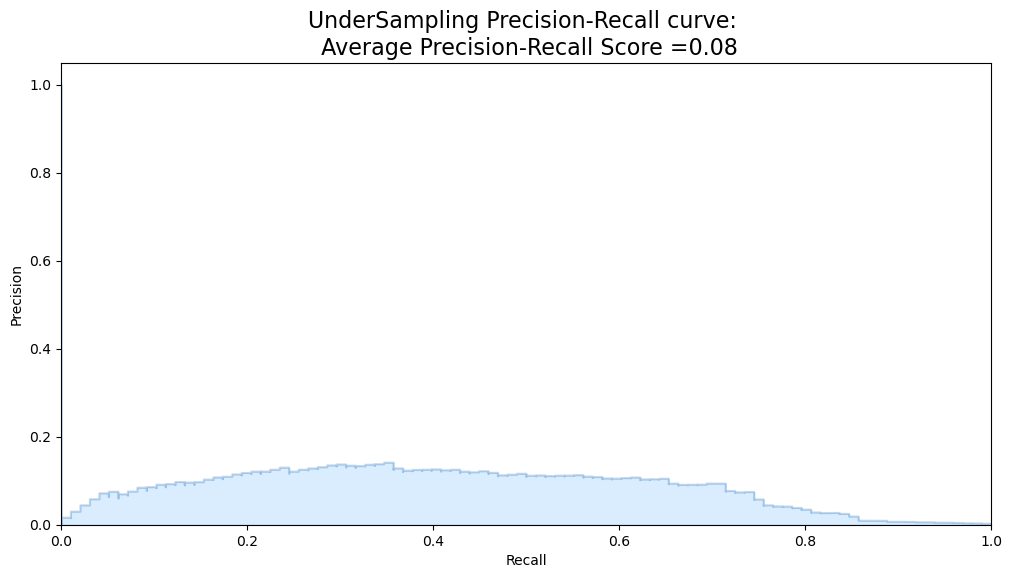

In [48]:

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersampled_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersampled_average_precision), fontsize=16)